In [1]:
""" 
Server Description:

0) Server System: Dell Precision 5520 series with 32 GB RAM and 2Tb SSD

1) Devices available:

    Nvidia Quadro GPU- 1

    Intel Graphics Card- 1 

    Intel octacore i7 7th gen processor- 1

    (1 processor to be used as host)

2) Request format:

    Requests come as tasks through python's socket programming 

3) Tasks:
     
     (Image processing and ML oriented kernels with accurate input and output dimension description)
     
     Input data and output data shape
     
     task dependent data description 
     
"""

" \nServer Description:\n\n0) Server System: Dell Precision 5520 series with 32 GB RAM and 2Tb SSD\n\n1) Devices available:\n\n    Nvidia Quadro GPU- 1\n\n    Intel Graphics Card- 1 \n\n    Intel octacore i7 7th gen processor- 1\n\n    (1 processor to be used as host)\n\n2) Request format:\n\n    Requests come as tasks through python's socket programming \n\n3) Tasks:\n     \n     (Image processing and ML oriented kernels with accurate input and output dimension description)\n     \n     Input data and output data shape\n     \n     task dependent data description \n     \n"

In [2]:
import numpy as np

import pyopencl as cl

import matplotlib.pyplot as plt

import math

import random 

import multiprocessing

import socket

import time


In [3]:
""" Set up the server's platform and devices """

platforms= cl.get_platforms()

platform_GPU0= [platform for platform in platforms if platform.name== "Intel(R) OpenCL HD Graphics"][0]

platform_GPU1= [platform for platform in platforms if platform.name== "NVIDIA CUDA"][0]

platform_CPU= [platform for platform in platforms if platform.name== "Intel(R) OpenCL"][0]

devices_GPU0= platform_GPU0.get_devices()

devices_CPU= platform_CPU.get_devices()

devices_GPU1= platform_GPU1.get_devices()

devices_GPU1[0].get_info(cl.device_info.MAX_COMPUTE_UNITS)


5

In [4]:
def next_state(x):
    
    if(x==1):
        
        return 0
    
    else:
        
        x+=1
        
        return x

In [5]:
""" Queue Task Scheduler for the server """

""" 
Task Architecture:

1) kernel

2) input_data

3) output_data_bytes 

"""

class Task_Scheduler:
    
    """ This task scheduler assumes that all the devices have same number queues which is usually not the case"""
    
    """ Weighted Round Robin Scheduler """
    
    def __init__(self):
        
        self.num_devices= 2
        
        self.num_queues= 3
        
        self.device_state=0
        
        self.next_device_state=0
        
        self.c_count=0
        
        self.n_count=1
        
    def device_update_state(self):
        
        self.device_state= self.next_device_state
        
        self.c_count= self.n_count
        
        if(self.device_state== 0):
            
            if(self.c_count!= 24):
                
                self.next_device_state= self.device_state
                
                self.n_count= self.c_count+1
                
            elif(self.c_count== 24):
                
                self.next_device_state= next_state(self.device_state)
                
                self.n_count=0
                
                
        if(self.device_state==1):
            
            if(self.c_count!= 5):
                
                self.next_device_state= self.device_state
                
                self.n_count= self.c_count+1
                
            elif(self.c_count== 5):
                
                self.next_device_state= next_state(self.device_state)
                
                self.n_count=0
        
        return None 
    
    def offload_to_device(self, task):
        
        server= Server()
        
        device= self.device_state
        
        if(device==0):
            
            q_index= random.randint(0,2)
            
            server.create_device_queues(self.num_queues)
            
            Buffers, prg= server.configure_host_device(server.ctx_gpu0, server.queues_gpu0[q_index], task[0], task[1], task[2])
            
            server.enqueue_task(server.ctx_gpu0, server.queues_gpu0[q_index], prg, Buffers)
            
            out= server.copy_device_host(server.queues_gpu0[q_index], Buffers, task[2])
            
            server.free_buffers(Buffers)
            
        if(device==1):
            
            q_index= random.randint(0,2)
            
            server.create_device_queues(self.num_queues)
            
            Buffers, prg= server.configure_host_device(server.ctx_gpu1, server.queues_gpu1[q_index], task[0], task[1], task[2])
            
            server.enqueue_task(server.ctx_gpu1, server.queues_gpu1[q_index], prg, Buffers)
            
            out= server.copy_device_host(server.queues_gpu1[q_index], Buffers, task[2])
            
            server.free_buffers(Buffers)
            
        return out


In [6]:
""" 
Server Module:

hardware and software functionalities are defined here 

Server is assumed to have all the devices mentioned in the description 

"""
class Server:
    
    def __init__(self):
        
        """ server device level info"""
        
        self.device_gpu0= devices_GPU0
        
        self.device_gpu1= devices_GPU1
        
        self.device_cpu= devices_CPU
        
        """ contexts for the device installed on server """
        
        self.ctx_gpu0= cl.Context(devices_GPU0)
        
        self.ctx_gpu1= cl.Context(devices_GPU1)
        
        self.ctx_cpu= cl.Context(devices_CPU)
        
        """ queues for each devices (pointers will be stored in lists) """
        
        self.queues_gpu0= []
        
        self.queues_gpu1= []
        
        self.queues_cpu= []
        
    """ create_device_queue creates command queue objects for all the defined devices. """
        
    def create_device_queues(self, num_queues):
        
        for i in range(num_queues):
            
            self.queues_gpu0.append(cl.CommandQueue(self.ctx_gpu0))
            
            self.queues_gpu1.append(cl.CommandQueue(self.ctx_gpu1))
            
            self.queues_cpu.append(cl.CommandQueue(self.ctx_cpu))
            
        return None
            
    """ 
    input_data structure:
    
    2d numpy array containing all the input tasks of the kernel 
    
    Out_data structure:
    
    1d array containing size of each output of the data
    """
    
    def configure_host_device(self, ctx, queue, kernel, input_data, out_data):
        
        Buffers_in= []
        
        Buffers_out= []
        
        prg= cl.Program(ctx, kernel).build()
        
        for i in range(len(input_data)):
            
            buffer= cl.Buffer(ctx, cl.mem_flags.READ_ONLY, size= input_data[i].nbytes)
            
            Buffers_in.append(buffer)
            
            cl.enqueue_copy(queue, src= input_data[i], dest= buffer)
            
        for i in range(len(out_data)):
            
            Buffers_out.append(cl.Buffer(ctx, cl.mem_flags.READ_WRITE, size= out_data[i]))
            
        Buffers= Buffers_out+Buffers_in 
        
        return (Buffers, prg)
    
    """ following routine assumes that kernel arguments are in desired order i.e out --> in """
    
    def enqueue_task(self, ctx, queue, prg, Buffers):
                
        prg.process(queue,(1000,), (10,), *Buffers)
      
        return None
        
    """ compute data given back to the host"""
    
    def copy_device_host(self, queue, Buffers, out_data):
        
        output= []
        
        for i in range(len(out_data)):
            
            len_arr= int(out_data[i]/4)
            
            temp_host= np.array([0 for i in range(len_arr)], dtype= np.float32)
            
            out_host= np.empty_like(temp_host)
            
            cl.enqueue_copy(queue, src= Buffers[i], dest= out_host)
            
            output.append(out_host)
        
        return output
    
    """ Release buffers once computing is done and data is transfered to the host """
    
    def free_buffers(self, Buffers):
        
        for i in range(len(Buffers)):
            
            Buffers[i].release()
        
        return None

In [7]:
""" kernel space """

kernel= """

__kernel void process(__global float* c, __global float* a, __global float* b)
{

 int gid= get_global_id(0);
 
 c[gid]= a[gid]+b[gid];
 
}

"""

In [8]:
""" Server Simulation """

input_data= np.array([[i for i in range(1000)] for i in range(2)], dtype= np.float32)

out_data= [input_data[0].nbytes]

tasks= [[kernel, input_data, out_data] for i in range(100)]

task_scheduler= Task_Scheduler()

times= []

intel_device= 0

nvidia_device= 1

device_state= 0

intel_device_load= 0

nvidia_device_load= 0

load_intel= []

load_nvidia= []

time_slots= 100

""" Server is run for 100 time slots. At each time slot, server receives random tasks from the users."""
""" the scheduler schedules the tasks at the hardware platform"""

for slot in range(time_slots):
    
    tasks= [[kernel, input_data, out_data] for i in range(random.randint(1,100))]
    
    intel_device_load= 0
    
    nvidia_device_load= 0 

    for task in tasks:

        if(device_state == intel_device):

            intel_device_load+=1

        elif(device_state == nvidia_device):

            nvidia_device_load+=1

        start= time.time()

        task_scheduler.offload_to_device(task)

        end= time.time()

        times.append((end-start)*10**3)

        task_scheduler.device_update_state()

        device_state= task_scheduler.device_state

    load_intel.append(intel_device_load)

    load_nvidia.append(nvidia_device_load)



Text(0.5, 1.0, 'Execution time on the heterogenous platform')

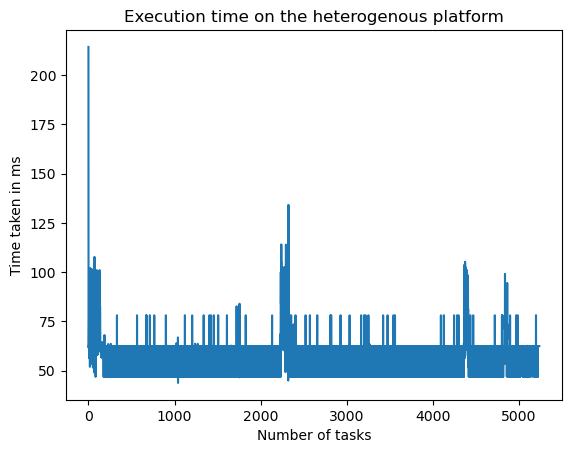

In [9]:
X= [i for i in range(len(times))]

plt.plot(X, times)

plt.xlabel("Number of tasks")

plt.ylabel("Time taken in ms")

plt.title("Execution time on the heterogenous platform")

In [10]:
"""average compute time of generated tasks on the given platforms"""

avg= np.mean(times)

print(avg)

60.37618082110621


Text(0.5, 1.0, 'Load on Intel graphics card at each time slot')

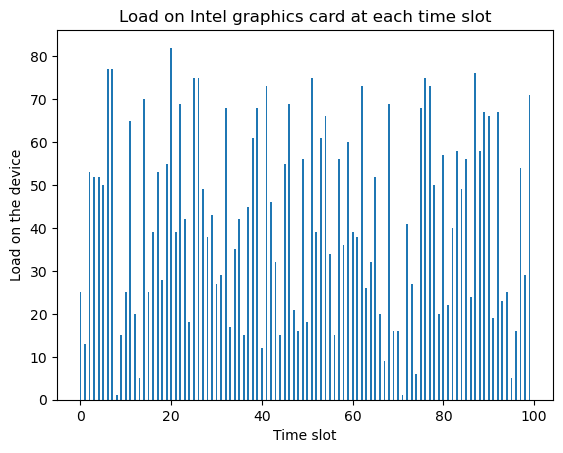

In [11]:
#print(load_intel)
#print(load_nvidia)

X= [i for i in range(100)]

plt.bar(X, load_intel, width= 0.4)

plt.xlabel("Time slot")

plt.ylabel("Load on the device")

plt.title("Load on Intel graphics card at each time slot")


Text(0.5, 1.0, 'Load on Nvidia Quadro M1200 GPU at each time slot')

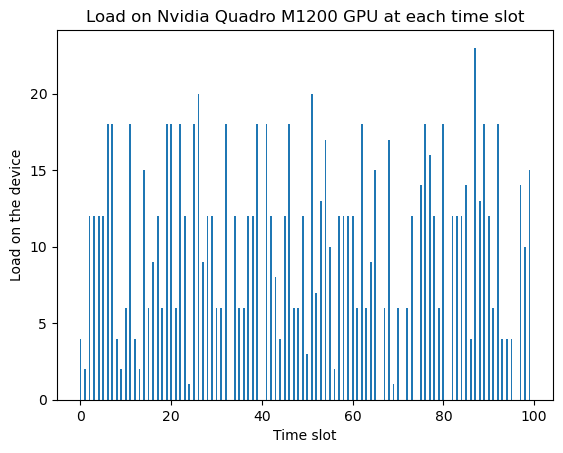

In [12]:
plt.bar(X, load_nvidia, width= 0.4)

plt.xlabel("Time slot")

plt.ylabel("Load on the device")

plt.title("Load on Nvidia Quadro M1200 GPU at each time slot")



In [13]:
print(np.mean(times))

print(np.mean(load_intel))

print(np.mean(load_nvidia))

60.37618082110621
42.25
10.11
